### Load Mujoco Engine

In [2]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [3]:
xml_path = '../../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder

### Get gripper joint indexes

In [4]:
gripper_joint_idxs = []

for gripper_idx in env.rev_joint_idxs:
    if gripper_idx not in env.idxs_forward:
        gripper_joint_idxs.append(gripper_idx)
print(f"Gripper joint idxs: {gripper_joint_idxs}")

Gripper joint idxs: [6, 7, 8, 9, 10, 11]


In [5]:
q_init = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]
q_close_grasp = [-0.03, -0.0273, -0.03, 0.03, 0.0273, 0.03]

### `Collision` detection

In [6]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=False) # transparent
env.update_viewer(VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.update_viewer(VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset

# Open gripper (prismatic joints)
env.forward(q=np.array([0,0,0,0,90,0])*np.pi/180.0,joint_idxs=env.idxs_forward)
# Set the primary and the secondary IK targets
ik_body_name = 'tcp_link'
p_trgt = np.array([0.9, -0.1, 0.9])
R_trgt = rpy2r(np.array([-180,0,180])*np.pi/180.0)

# Loop
q = env.get_q(joint_idxs=env.idxs_forward)
imgs,img_ticks,max_tick = [],[],1000
while (env.tick < max_tick) and env.is_viewer_alive():
    # Get IK ingredients for the primary target
    J,err = env.get_ik_ingredients(
        body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True)
    dq = env.damped_ls(J,err,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    # Update q and FK
    q = q + dq[env.idxs_jacobian]
    env.forward(q=q,joint_idxs=env.idxs_forward) # FK
    env.forward(q=q_close_grasp, joint_idxs=gripper_joint_idxs)
    # Get contact information
    p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(
        must_include_prefix='ur_')
    # env.step(ctrl=np.array([1.0]), ctrl_idxs=6)

    # Render
    env.plot_T(p=env.get_p_body(body_name=ik_body_name),
               R=env.get_R_body(body_name=ik_body_name),
               PLOT_AXIS=True,axis_len=0.2,axis_width=0.005,PLOT_SPHERE=False)
    env.plot_T(p=p_trgt,R=R_trgt,PLOT_AXIS=True,axis_len=0.2,axis_width=0.005,
               PLOT_SPHERE=False)
    # Render contact informations
    for (p_contact,f_contact,geom1,geom2) in zip(p_contacts,f_contacts,geom1s,geom2s):
        f_norm = np.linalg.norm(f_contact)
        f_uv = f_contact / (f_norm+1e-8)
        f_len = 0.3 # f_norm*0.05
        env.plot_arrow(p=p_contact,uv=f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,1],
                       label='')
        env.plot_arrow(p=p_contact,uv=-f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,1],
                       label='')
        label = 'Contact point' # '[%s]-[%s]'%(geom1,geom2)
        env.plot_sphere(p=p_contact,r=0.02,rgba=[1,0.2,0.2,1],label=label)
    env.plot_T(p=[0,0,0],R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0)
    env.render()
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        print ("[%d/%d] IK error:[%.4f]"%(env.tick,max_tick,np.linalg.norm(err)))
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)
# Close viewer
env.close_viewer()
print ("Done.")

Pressed ESC
Quitting.
Done.


In [7]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
q_open = np.array([-0.33, -0.3 , -0.34,  0.38,  0.34,  0.36])
env.forward(q=q_open, joint_idxs=np.array([6,7,8,9,10,11]))

DO_RENDER = True
body_name = 'tcp_link'

p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(must_include_prefix='ur_')
R_trgt = rpy2r(np.radians([-180,0,90]))

while len(geom1s) == 2: # Break if there is only one contact: ur_rg2_gripper_finger1_finger_tip
    print(len(geom1s))
    print(geom1s)
    x_rand = np.random.uniform(low=0.5,high=1)
    y_rand = np.random.uniform(low=-0.3,high=0.3)
    z_rand = np.random.uniform(low=0.85,high=1.2)
    p_trgt = np.array([x_rand,y_rand,z_rand])

    q_backup = env.get_q(joint_idxs=env.idxs_forward)
    q = q_init.copy()
    env.forward(q=q,joint_idxs=env.idxs_forward)
    tick = 0
    while True:
        tick = tick + 1
        J,err = env.get_ik_ingredients(
            body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True)
        dq = env.damped_ls(J,err,stepsize=1,eps=1e-1,th=1*np.pi/180.0)
        q = q + dq[env.idxs_jacobian]
        env.forward(q=q,joint_idxs=env.idxs_forward)
        # Terminate condition
        err_norm = np.linalg.norm(err)
        if err_norm < 1e-3:
            break
        # Render
        if DO_RENDER:
            if ((tick-1)%1) == 0:
                p_tcp,R_tcp = env.get_pR_body(body_name=body_name)
                env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
                env.plot_T(p=p_trgt,R=R_trgt,PLOT_AXIS=True,axis_len=0.2,axis_width=0.005)
                env.render()
    # Back to back-uped position
    q_ik = env.get_q(joint_idxs=env.idxs_forward)
    env.forward(q=q_backup,joint_idxs=env.idxs_forward)
    env.forward(q=q_open, joint_idxs=np.array([6,7,8,9,10,11]))

    p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(must_include_prefix='ur_')

# Close viewer
env.close_viewer()
print ("Done.")

2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
2
['ur_forearm_link_2_collision', 'ur_wrist_1_link_collision']
Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

Pressed ESC
Quitting.


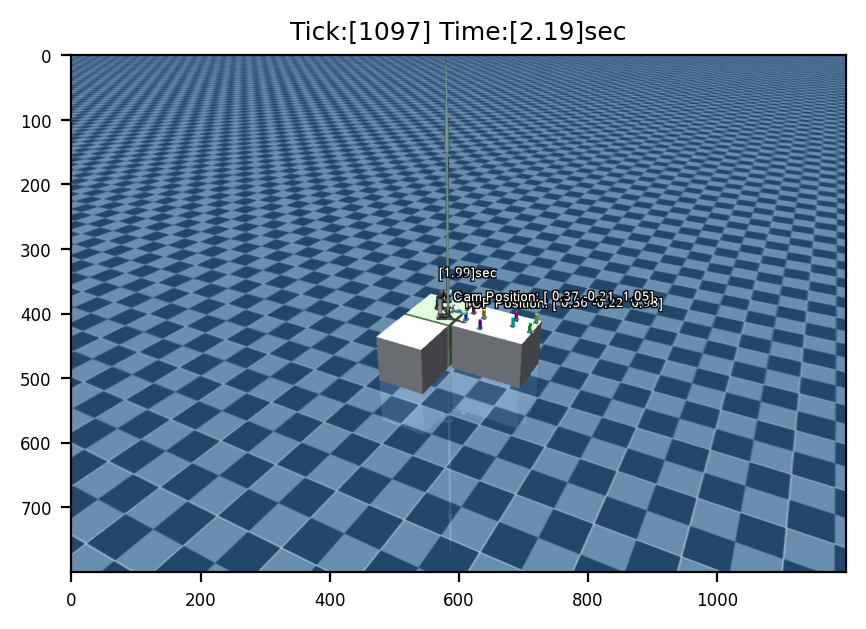

Done.


In [8]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=[-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105], joint_idxs=env.idxs_forward)


tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.step(ctrl=q_ik, ctrl_idxs=env.idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")